In [1]:
from src.hand_analysis.mapper.psychopy_mapper import PsychopyTMTMapper
from neurotask.tmt.tmt_analyzer import TMTAnalyzer
from src import config
from src.hand_analysis.runner.run_hand_analysis import run_analysis_with_configuration_parameters
analyzer = TMTAnalyzer(
        mapper=PsychopyTMTMapper(),
        dataset_path=config.PYXATIONS_PATIENTS_DATA_DIR,
        output_path=config.DATA_DIR
    )
#analysis = run_analysis_with_configuration_parameters(config.DATA_DIR)
experiment = analyzer.get_experiment()

In [2]:
subject = experiment.subjects["0063"]
subject

TMTSubject(training_trials=[], testing_trials=[TMTTrial(stimuli=[TMTTarget(content='1', position=Coordinate(x=-0.20191733333333317, y=-0.2820346666666667)), TMTTarget(content='2', position=Coordinate(x=-0.1183973333333332, y=-0.3655546666666667)), TMTTarget(content='3', position=Coordinate(x=-0.14623733333333336, y=-0.1706746666666666)), TMTTarget(content='4', position=Coordinate(x=-0.25759733333333334, y=-0.11499466666666662)), TMTTarget(content='5', position=Coordinate(x=-0.007037333333333234, y=-0.1706746666666666)), TMTTarget(content='6', position=Coordinate(x=0.16000266666666654, y=-0.11499466666666662)), TMTTarget(content='7', position=Coordinate(x=0.2435226666666667, y=0.13556533333333332)), TMTTarget(content='8', position=Coordinate(x=0.38272266666666666, y=0.24692533333333327)), TMTTarget(content='9', position=Coordinate(x=0.2713626666666667, y=-0.059314666666666634)), TMTTarget(content='10', position=Coordinate(x=0.41056266666666663, y=0.1634053333333333)), TMTTarget(content=

In [3]:

from neurotask.tmt.metrics.speed_metrics import calculate_speeds_between_cursor_positions
from neurotask.tmt.metrics.speed_metrics import calculate_accelerations_between_cursor_positions
from matplotlib import pyplot as plt
from neurotask.tmt.model.tmt_model import TMTTrial


def plot_with_color(trial: TMTTrial, canvas_size: int, target_radius: float, color_by='time'):
    """
    Plotea la trayectoria del cursor junto con los targets en un gráfico,
    ajustando el tamaño del gráfico al tamaño del canvas y dibujando círculos
    alrededor de los targets con su contenido. La trayectoria del cursor se
    dibuja con puntos cuyos colores cambian en función del tiempo, la velocidad o la aceleración.
    El primer clic en el target se destaca con un marcador especial.

    Parameters:
    - trial: TMTTrial, el trial con la trayectoria del cursor y los targets.
    - canvas_size: int, tamaño del canvas (ancho y alto).
    - target_radius: float, radio de los círculos que rodean los targets.
    - color_by: str, 'time', 'speed' o 'acceleration', determina si el color de los puntos cambia en función del tiempo, velocidad o aceleración.
    """

    # Extraer la posición de los targets
    target_x = [target.position.x for target in trial.stimuli]
    target_y = [target.position.y for target in trial.stimuli]
    target_contents = [target.content for target in trial.stimuli]

    cursor_trail_from_first_click = trial.cursor_trail #.get_cursor_trail_from_start()
    # Extraer la trayectoria del cursor
    cursor_x = [cursor_info.position.x for cursor_info in cursor_trail_from_first_click]
    cursor_y = [cursor_info.position.y for cursor_info in cursor_trail_from_first_click]
    cursor_times = [cursor_info.time for cursor_info in cursor_trail_from_first_click]

    if color_by == 'time':
        # Normalizar tiempos para que estén en el rango [0, 1]
        norm = plt.Normalize(min(cursor_times), max(cursor_times))
        colors = plt.cm.viridis(norm(cursor_times))  # Usar un mapa de colores para el tiempo
    elif color_by == 'speed':
        speeds = calculate_speeds_between_cursor_positions(trial)
        speeds = [0] + speeds  # Para igualar el número de puntos con las velocidades calculadas
        norm = plt.Normalize(min(speeds), max(speeds))
        colors = plt.cm.viridis(norm(speeds))  # Usar un mapa de colores para la velocidad
    elif color_by == 'acceleration':
        accelerations = calculate_accelerations_between_cursor_positions(trial)
        accelerations = [0, 0] + accelerations  # Igualar el número de puntos (2 primeros puntos sin aceleración)
        norm = plt.Normalize(min(accelerations), max(accelerations))
        colors = plt.cm.viridis(norm(accelerations))  # Usar un mapa de colores para la aceleración
    else:
        raise ValueError("El parámetro color_by debe ser 'time', 'speed' o 'acceleration'.")

    # Crear el gráfico
    fig, ax = plt.subplots(figsize=(8, 8))

    # Dibujar la trayectoria del cursor como líneas coloreadas por tiempo o velocidad
    for i in range(len(cursor_x) - 1):
        plt.plot([cursor_x[i], cursor_x[i + 1]],
                 [cursor_y[i], cursor_y[i + 1]],
                 color=colors[i], linewidth=2, zorder=4)

    # Dibujar los targets como círculos con el contenido dentro
    for x, y, content in zip(target_x, target_y, target_contents):
        circle = plt.Circle((x, y), target_radius, color='red', alpha=0.3, zorder=5)
        plt.gca().add_patch(circle)
        # Añadir el contenido del target en el centro del círculo
        plt.text(x, y, content, color='black', fontsize=8, ha='center', va='center', zorder=6)

    # Destacar el primer clic
    if trial.start:
        fc_x = trial.start.position.x
        fc_y = trial.start.position.y
        plt.scatter(fc_x, fc_y, color='cyan', edgecolor='black', s=100, label='First Click', zorder=7,
                    marker='o', alpha=0.3)

    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    cbar_label = 'Time' if color_by == 'time' else 'Speed' if color_by == 'speed' else 'Acceleration'
    cbar = fig.colorbar(sm, ax=ax, label=cbar_label)

    # # Set plot limits based on canvas size
    # ax.set_xlim(-canvas_size, canvas_size)
    # ax.set_ylim(canvas_size, -canvas_size,)  # Inverted Y-axis if needed

    # Add labels and title
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title('Cursor Trail with Targets')

    # Ensure equal aspect ratio
    ax.set_aspect('equal', adjustable='box')

    # Add legend
    ax.legend()

    return fig

In [4]:
from src.hand_analysis.loader.load_last_split import load_last_analysis
train_set, _ = load_last_analysis()
subject_analysis = train_set[train_set['subject_id'] == 63]
subject_analysis

,subject_id,trial_id,trial_type,is_valid,trial_order_of_appearance,speed_threshold,non_cut_zigzag_amplitude,non_cut_total_distance,non_cut_rt,non_cut_mean_speed,...,wrong_targets_touches,number_of_crosses,distance_difference_from_ideal,area_difference_from_ideal,intra_target_time,inter_target_time,invalid_cause,sex,age,group
1160,63,7,PART_A,True,2,0.204387,NaN,3.329216,20958.0,0.207175,...,1.0,NaN,0.039214,0.001913,1.174177,0.336323,NaN,F,52,HC
1161,63,12,PART_B,False,3,0.204387,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,CUT_CRITERIA_ERROR,F,52,HC
1162,63,1,PART_A,True,4,0.204387,NaN,5.191925,23676.0,0.217452,...,0.0,NaN,0.052557,0.002286,1.762604,0.352928,NaN,F,52,HC
1163,63,20,PART_B,True,5,0.204387,-1.471701,3.428806,22257.0,0.178895,...,0.0,NaN,0.041064,0.001707,1.399936,0.336265,NaN,F,52,HC
1164,63,11,PART_A,True,6,0.204387,NaN,3.653822,19301.0,0.230362,...,3.0,NaN,0.026195,0.001918,1.157791,0.333202,NaN,F,52,HC
1165,63,13,PART_B,True,7,0.204387,-1.347169,3.733872,18216.0,0.236058,...,1.0,NaN,0.042931,0.006787,1.245528,0.332657,NaN,F,52,HC
1166,63,17,PART_A,True,8,0.204387,NaN,3.023647,17425.0,0.225243,...,0.0,NaN,0.023258,0.002350,0.945813,0.329654,NaN,F,52,HC
1167,63,0,PART_B,True,9,0.204387,-1.621683,3.661062,20223.0,0.196249,...,1.0,NaN,0.019079,0.001673,1.476095,0.329720,NaN,F,52,HC
1168,63,5,PART_A,True,10,0.204387,NaN,4.285932,18688.0,0.284322,...,1.0,NaN,0.087488,0.003140,1.188886,0.324500,NaN,F,52,HC
1169,63,10,PART_B,True,11,0.204387,-1.613930,3.840618,22569.0,0.200522,...,2.0,NaN,0.043238,0.002624,1.552952,0.320030,NaN,F,52,HC


Trial ID: 7
Trial Type: TrialType.PART_A
Trial order: 2
7


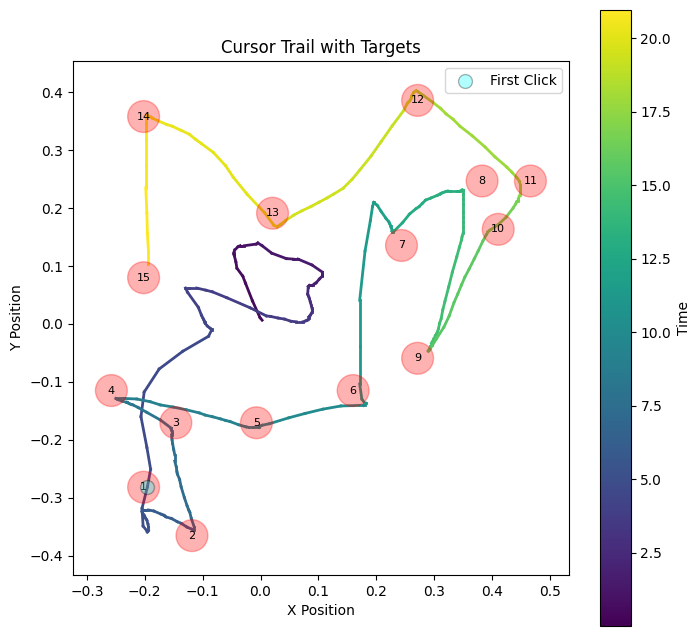

-----------------------------------------------

Trial ID: 12
Trial Type: TrialType.PART_B
Trial order: 3
0


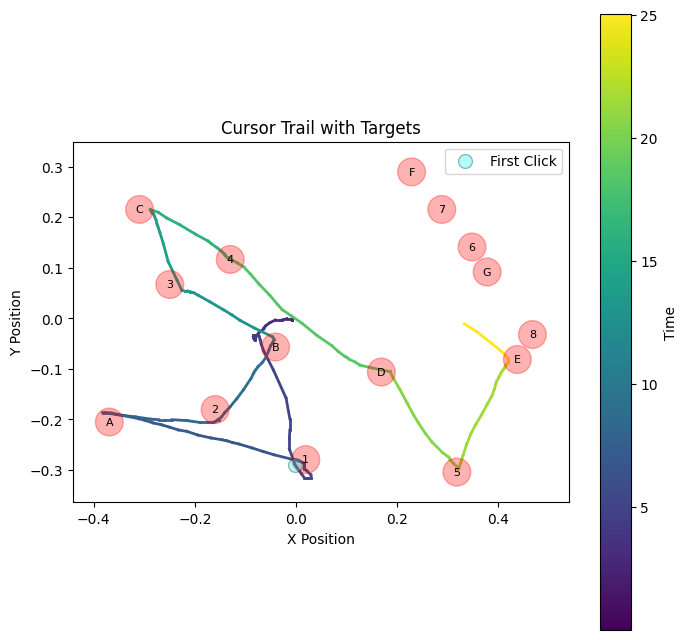

-----------------------------------------------

Trial ID: 1
Trial Type: TrialType.PART_A
Trial order: 4
2


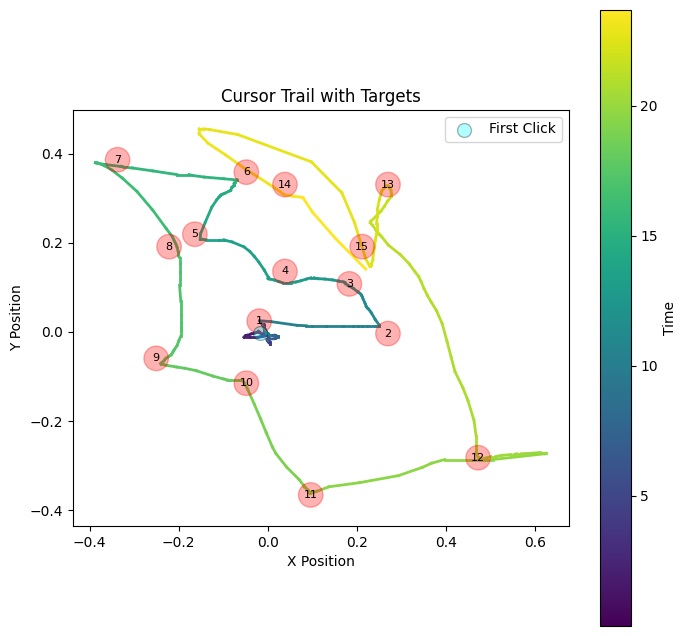

-----------------------------------------------

Trial ID: 20
Trial Type: TrialType.PART_B
Trial order: 5
1


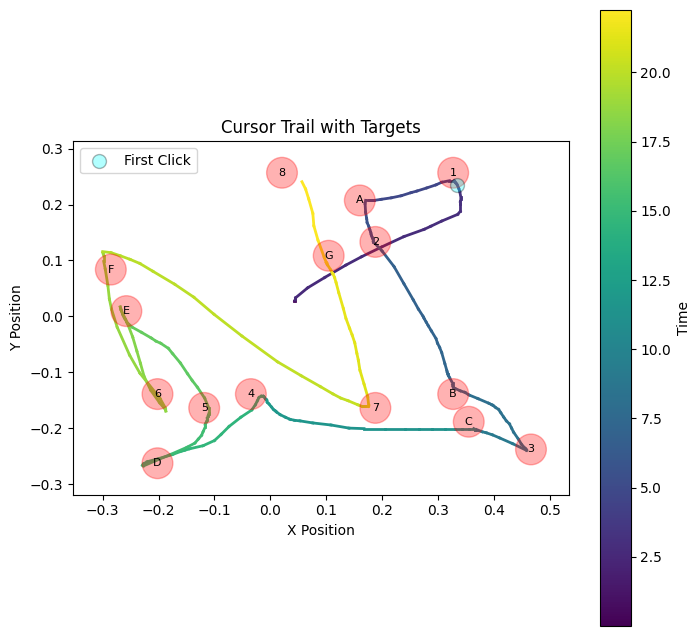

-----------------------------------------------

Trial ID: 11
Trial Type: TrialType.PART_A
Trial order: 6
1


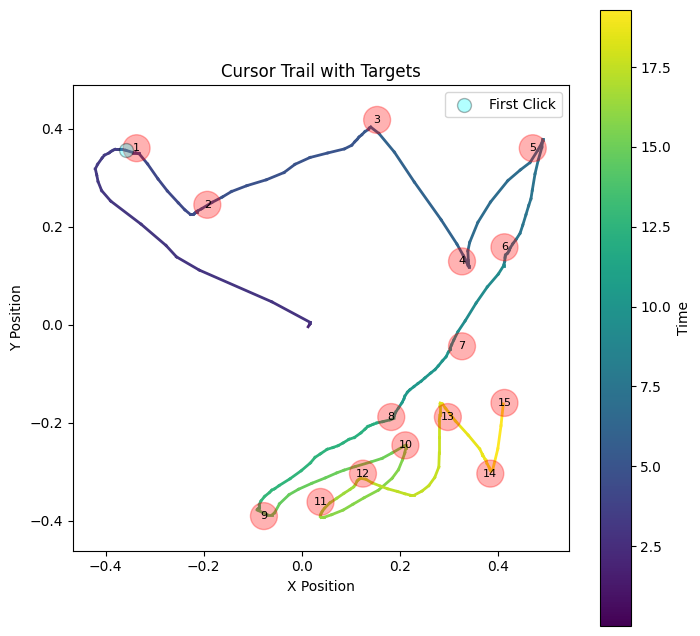

-----------------------------------------------

Trial ID: 13
Trial Type: TrialType.PART_B
Trial order: 7
0


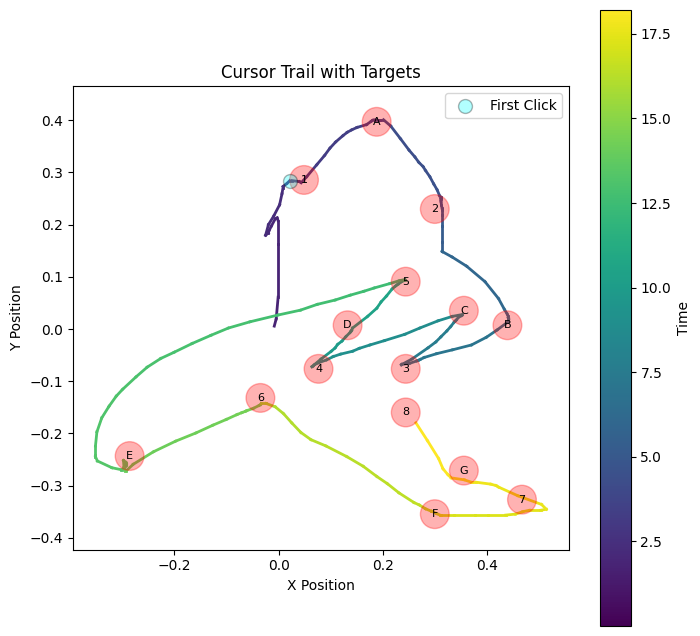

-----------------------------------------------

Trial ID: 17
Trial Type: TrialType.PART_A
Trial order: 8
5


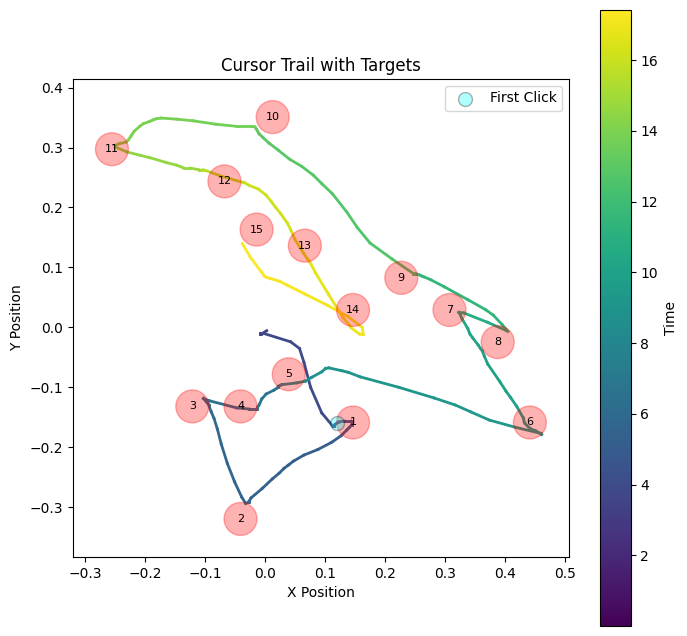

-----------------------------------------------

Trial ID: 0
Trial Type: TrialType.PART_B
Trial order: 9
0


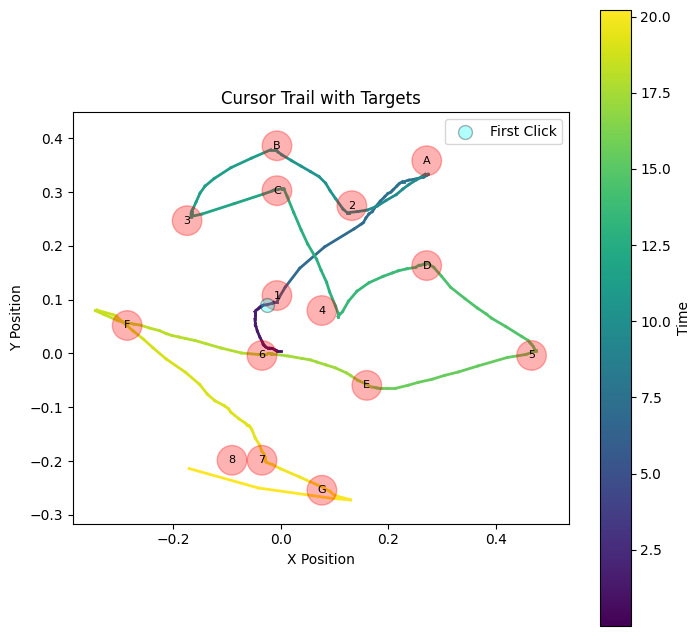

-----------------------------------------------

Trial ID: 5
Trial Type: TrialType.PART_A
Trial order: 10
1


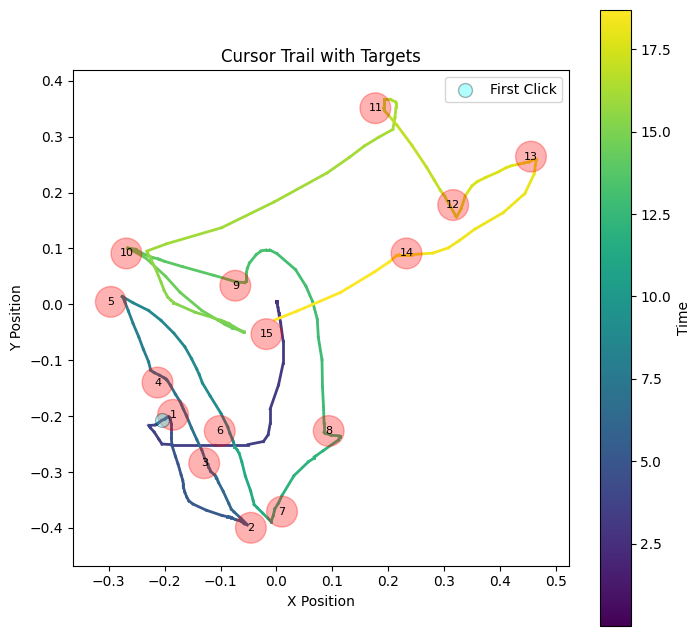

-----------------------------------------------

Trial ID: 10
Trial Type: TrialType.PART_B
Trial order: 11
12


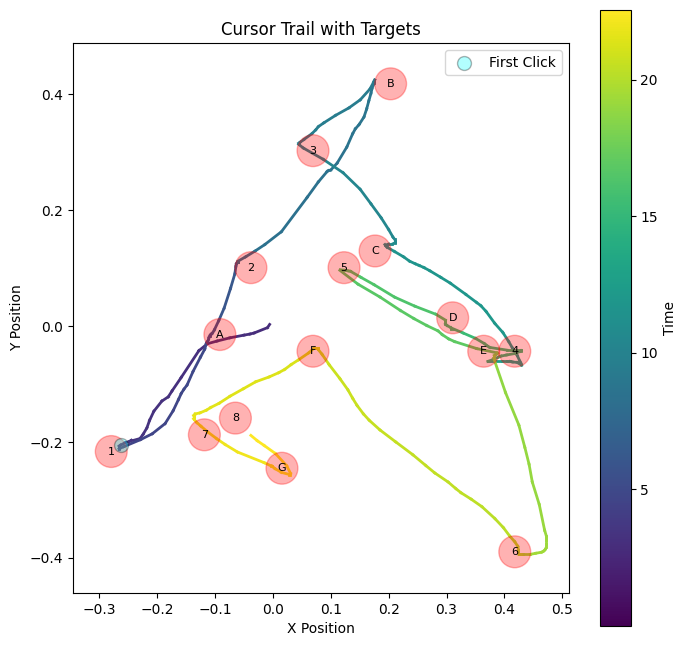

-----------------------------------------------

Trial ID: 9
Trial Type: TrialType.PART_A
Trial order: 12
7


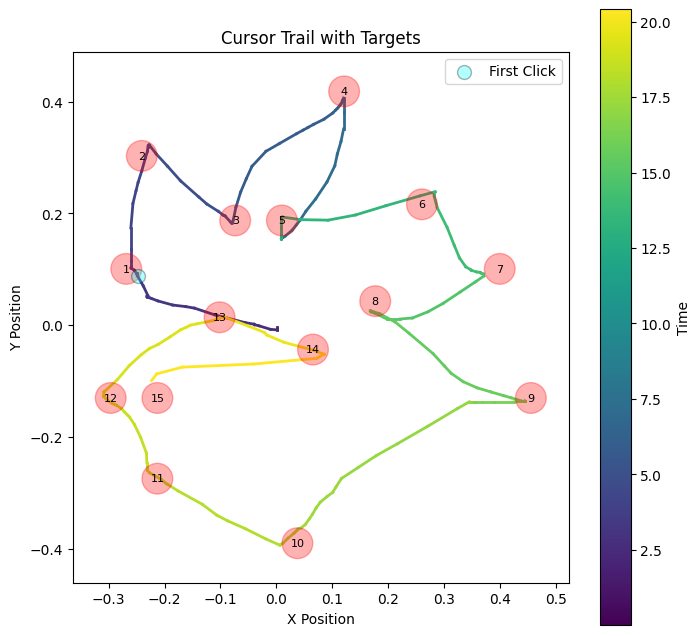

-----------------------------------------------

Trial ID: 16
Trial Type: TrialType.PART_B
Trial order: 13
0


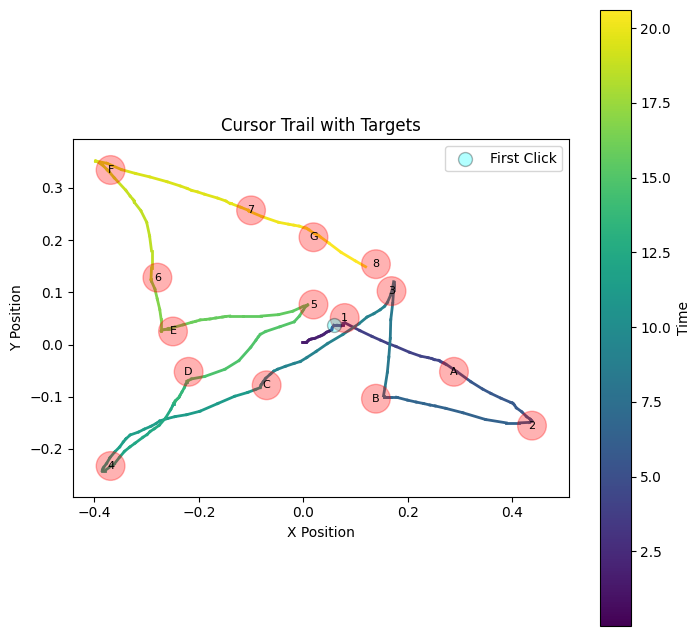

-----------------------------------------------

Trial ID: 15
Trial Type: TrialType.PART_A
Trial order: 14
0


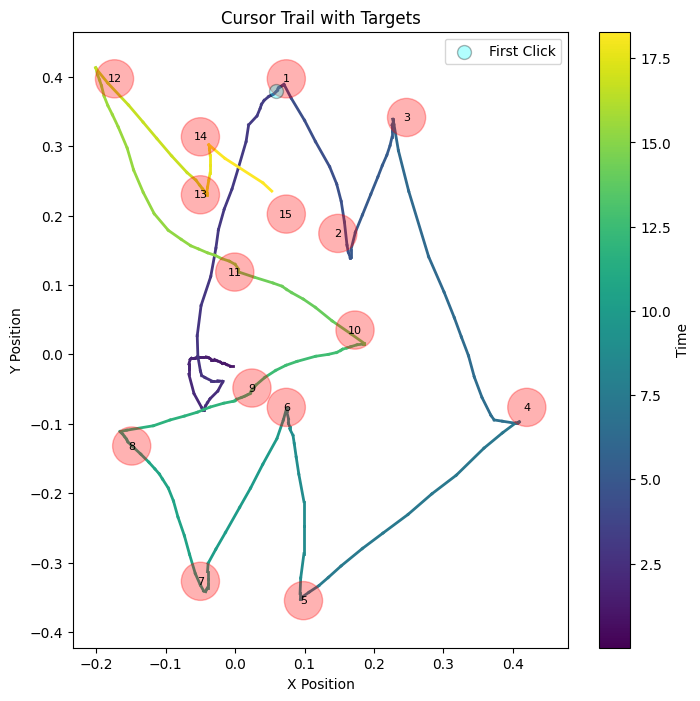

-----------------------------------------------

Trial ID: 2
Trial Type: TrialType.PART_B
Trial order: 15
0


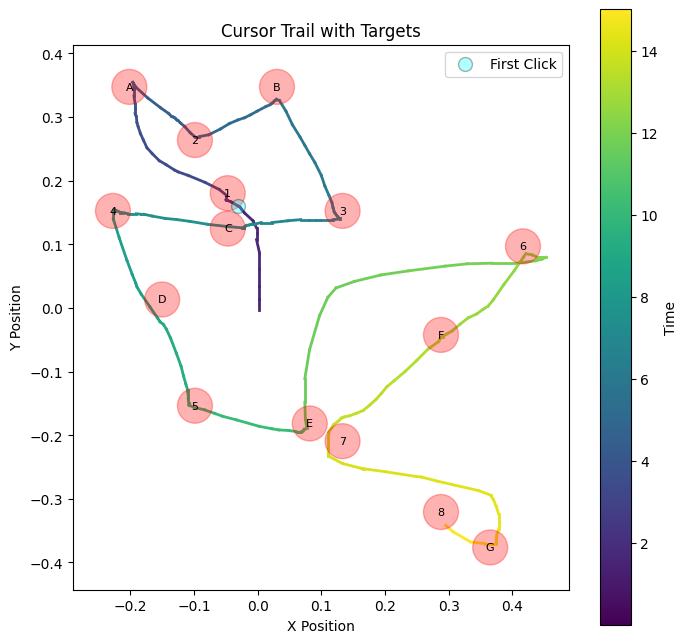

-----------------------------------------------

Trial ID: 3
Trial Type: TrialType.PART_A
Trial order: 16
11


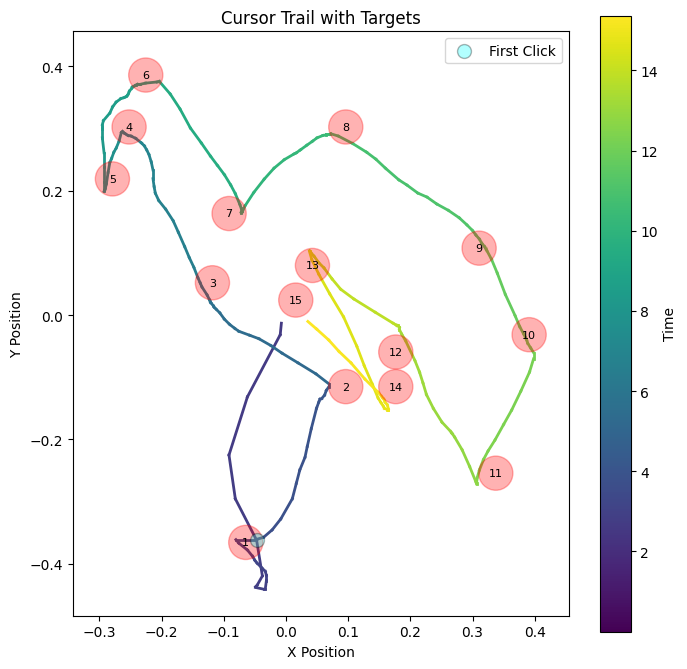

-----------------------------------------------

Trial ID: 8
Trial Type: TrialType.PART_B
Trial order: 17
8


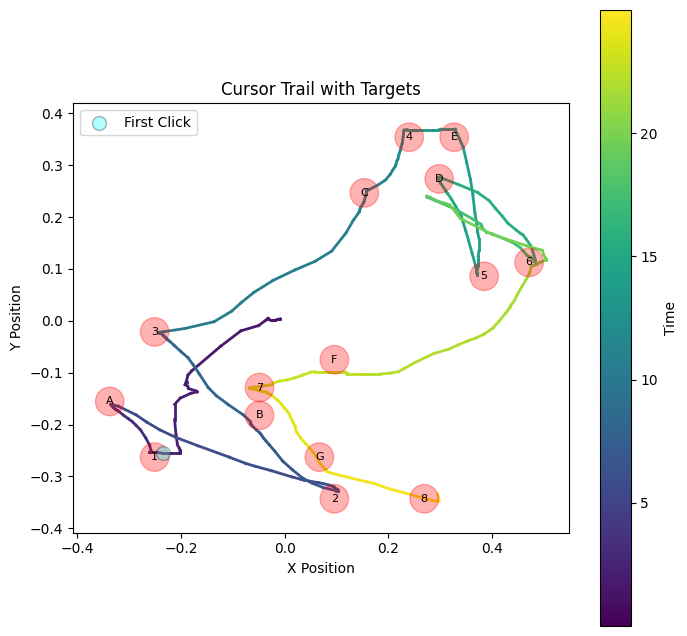

-----------------------------------------------

Trial ID: 6
Trial Type: TrialType.PART_A
Trial order: 18
11


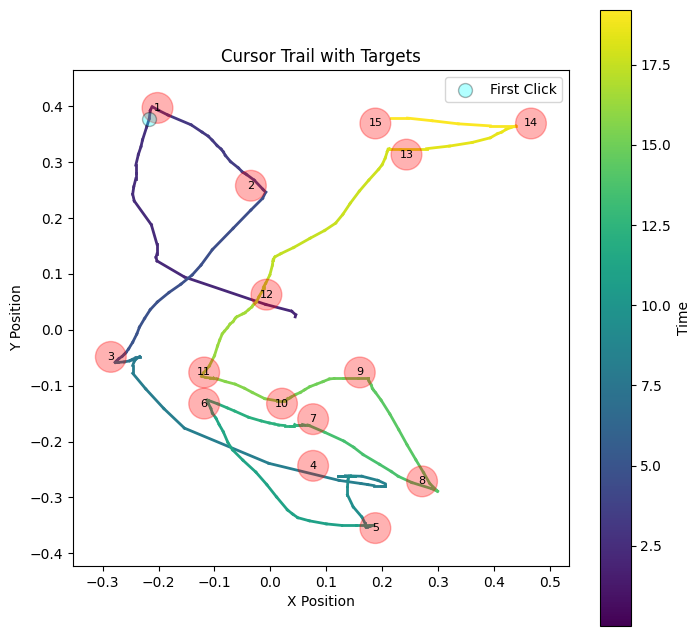

-----------------------------------------------

Trial ID: 4
Trial Type: TrialType.PART_B
Trial order: 19
7


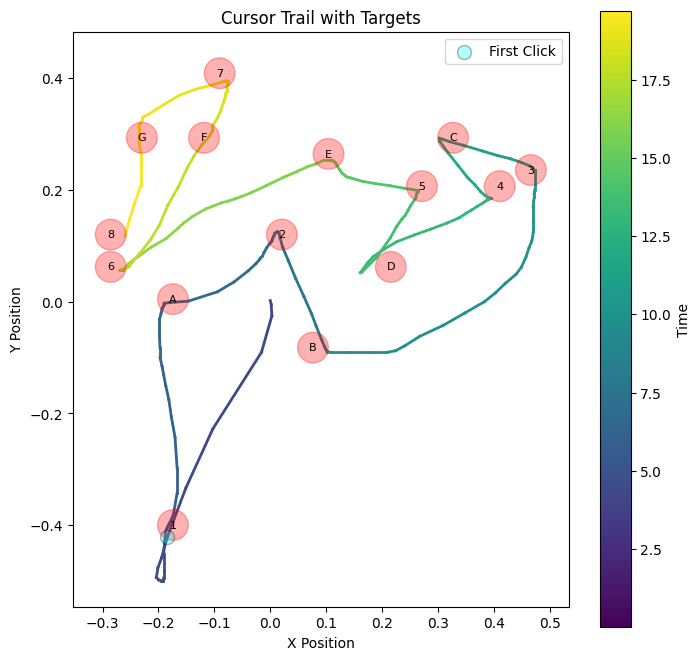

-----------------------------------------------

Trial ID: 19
Trial Type: TrialType.PART_A
Trial order: 20
14


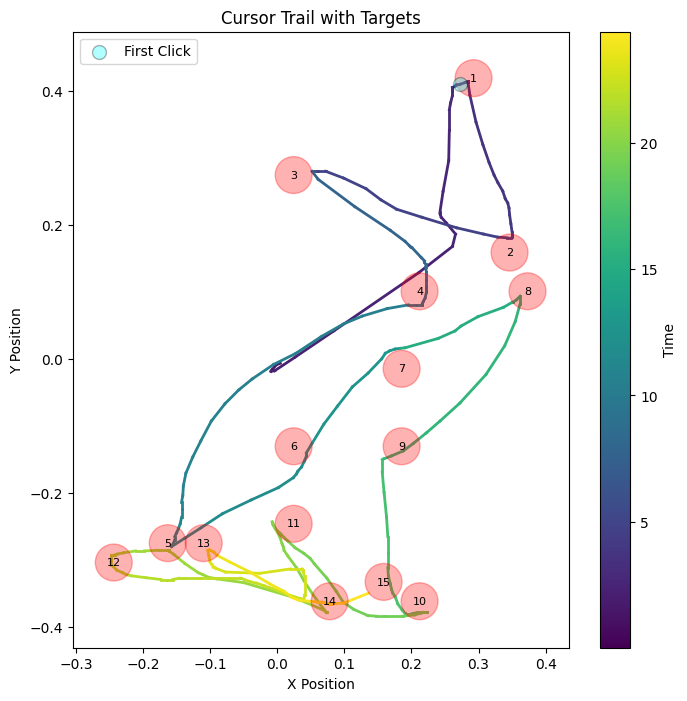

-----------------------------------------------

Trial ID: 21
Trial Type: TrialType.PART_B
Trial order: 21
14


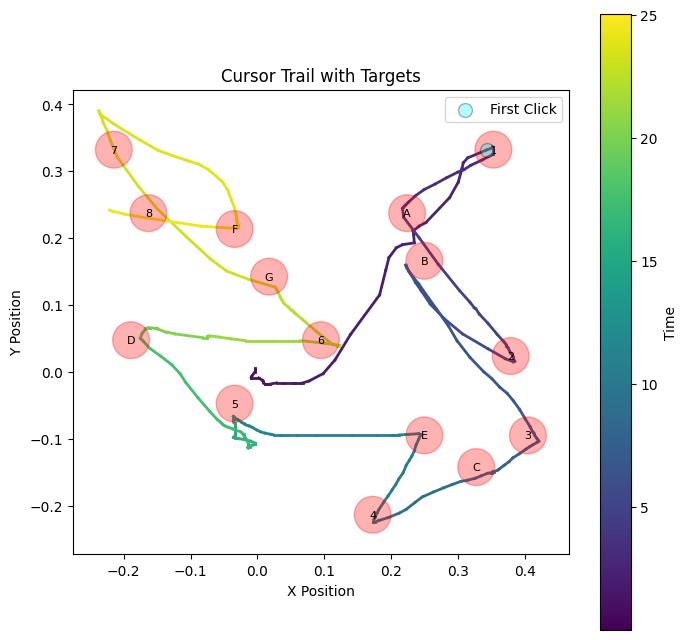

-----------------------------------------------



In [5]:
from neurotask.tmt.metrics.targets_touched  import *

for trial in subject.testing_trials:
    print("Trial ID:", trial.id)
    print("Trial Type:", trial.trial_type)
    print("Trial order:", trial.order_of_appearance)
    #print("Correct targets touches from analysis:", subject_analysis[subject_analysis['trial_id'] == trial.id]['non_cut_correct_targets_touches'].values[0])
    #print("Wrong targets touches from analysis:", subject_analysis[subject_analysis['trial_id'] == trial.id]['non_cut_wrong_targets_touches'].values[0])

    try:
        plot_with_color(trial, subject.canvas_size, subject.target_radius)
        a = count_incorrect_touches(trial, subject.target_radius)
        print(a)
        plt.show()
    except:
        print("ERROR PLOTTING TRIAL")
        continue
        
    print("-----------------------------------------------")
    print("")